In [1]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import matplotlib.pyplot as plt

import sys
sys.path.append('../../module/')

import keras2
from keras2.models import Model

from keras2.layers import concatenate, Dense, Input, Flatten, merge
from keras2.optimizers import Adam
from util import moving_average, dlqr, discretized_system, lqr, make_standup_agent
import gym2
from rl2.agents import selfDDPGAgent, selfDDPGAgent2
from rl2.memory import SequentialMemory

Using TensorFlow backend.
Using TensorFlow backend.


In [2]:
# GymのPendulum環境を作成
env = gym2.make("Pendulum-v2")

# 取りうる”打ち手”のアクション数と値の定義
nb_actios = 2
ACT_ID_TO_VALUE = {0: [-1], 1: [+1]}

In [3]:
def critic_net(a_shape , s_shape):
    action_input = Input(a_shape)
    observation_input = Input(shape=(1,)+s_shape)
    flattened_observation = Flatten()(observation_input)
    x = concatenate([action_input, flattened_observation])
    x = Dense(16, activation="relu")(x)
    x = Dense(16, activation="relu")(x)
    x = Dense(1, activation="linear")(x)
    critic = Model(inputs=[action_input, observation_input], outputs=x)
    return (critic, action_input)

def branch_actor(a_shape, s_shape):
    action_input = Input(shape=(1,)+s_shape)
    x = Flatten()(action_input) # 実質的なinput layer
    
    x1 = Dense(8, activation="relu")(x)
    x1 = Dense(8, activation="relu")(x1)
    x1 = Dense(1, activation="multiple_tanh")(x1) # action signal
    
    x2 = Dense(8, activation="relu")(x)
    x2 = Dense(8, activation="relu")(x2)
    x2 = Dense(1, activation="tau_output")(x2) # tau
    
    output = concatenate([x1, x2])
    actor = Model(inputs=action_input, outputs=output)
    return actor

def agent2(a_shape, s_shape):
    actor = branch_actor(a_shape, s_shape)
    critic,  critic_action_input = critic_net(a_shape, s_shape)
    memory = SequentialMemory(limit = 50000, window_length = 1)
    agent = selfDDPGAgent2(
        a_shape[0],
        actor,
        critic,
        critic_action_input,
        memory,
        clip_com = 0.01,
    )
    return agent

def gain(dt=None):
    m, l, g = env.m, env.l, env.g

    A = np.array([[0, 1], [(3*g)/(2*l), 0]])
    B = np.array([[0], [3/(m*l**2)]])
    Q = np.array([[1, 0], [0, 0.1]])
    R = np.array([[0.001]])
    
    if dt is not None:
        Ad, Bd = discretized_system(A, B, dt)  
        K = dlqr(Ad,Bd,Q,R)[0]
    else:
        K = lqr(A,B,Q,R)[0]
    
    return K

In [4]:
NN = branch_actor((2,),(2,))

In [26]:
# 学習データの用意
tau = 0.02
action_repetition = int(np.ceil(20 * tau))  # minimum natural number which makes `dt` smaller than 0.005
dt = tau / action_repetition
print(dt)
K = gain(dt)
x_train = []
y_train = []
high = np.array([np.pi, np.pi])
for i in range(30000):
    x_train.append([np.random.uniform(low=-high, high=high)])
    y_train.append([np.dot(K, x_train[-1][0]), tau])

x_train = np.array(x_train)
y_train = np.array(y_train)
print(x_train.shape, y_train.shape)

0.02
(30000, 1, 2) (30000, 2)


In [18]:
# learn
NN.compile(loss='mean_squared_error',optimizer='adam')
history = NN.fit(x_train, y_train, batch_size=128, epochs=100, verbose=0)

NameError: name 'NN' is not defined

In [28]:
# save
NN.save_weights('./saved_agent/tmp.h5')

In [20]:
a = agent2((2,), (2,))
a.compile(Adam(lr=0.001, clipnorm=1.), metrics=["mae"])
a.actor = make_standup_agent(a.actor, 0.2, env, epochs=100)
# a.actor.load_weights('./saved_agent/tmp.h5')

In [5]:
# validation
taus = []
for i in range(1000):
    x = np.random.randn(2,) / 10.
    a_agent, tau = a.forward(x)
    taus.append(tau)
    print(f'NN: {a_agent}, opt: {np.dot(K, x)}')
plt.plot(range(len(taus)), taus)
plt.plot(range(300, len(taus)), moving_average(taus, 300))
plt.show()

NameError: name 'K' is not defined

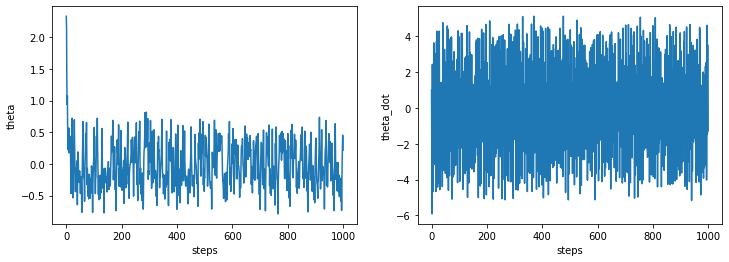

In [21]:
# 実環境テスト

def rad_clip(th):
    r = abs(th)
    while r > np.pi:
        r -= 2*np.pi
    th = np.sign(th) * r
    return th

env.reset()
states = []
taus = []
for i in range(1000):
    x = env.state
    states.append([rad_clip(x[0]), x[1]])
    a_agent, tau = a.forward(x)
    taus.append(tau)
    action_repetition = int(np.ceil(200 * tau))  # minimum natural number which makes `dt` smaller than 0.005
    dt = tau / action_repetition
    # print(tau, dt, action_repetition)
    for p in range(action_repetition):
        _,_,_,_ = env.step(np.array([a_agent]), dt, tau)
states = np.array(states)

plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.xlabel('steps')
plt.ylabel('theta')
plt.plot(range(states.shape[0]), states[:,0])
plt.subplot(1,2,2)
plt.xlabel('steps')
plt.ylabel('theta_dot')
plt.plot(range(states.shape[0]), states[:,1])
plt.show()

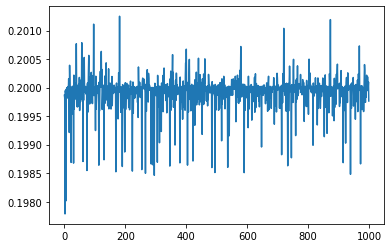

In [22]:
plt.plot(taus)

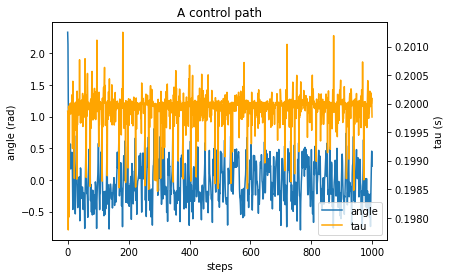

In [32]:
plt.figure()
ax1 = plt.subplot(1,1,1)
ax1.plot(states[:,0], label='angle')
ax2 = ax1.twinx()
ax2.plot(taus, color='orange', label='tau')
ax1.set_ylabel('angle (rad)')
ax2.set_ylabel('tau (s)')
plt.title('A control path')
ax1.set_xlabel('steps')
h1, l1 = ax1.get_legend_handles_labels()
h2, l2 = ax2.get_legend_handles_labels()
ax1.legend(h1+h2, l1+l2, loc='lower right')
plt.show()

In [27]:
memory = []
l = 5.
for i in range(8000):
    env.reset()
    state0 = env.state
    a_agent, tau = a.actor.predict_on_batch(np.array([[state0]]))[0]
    memory.append([state0[0], state0[1], tau])
memory = np.array(memory)

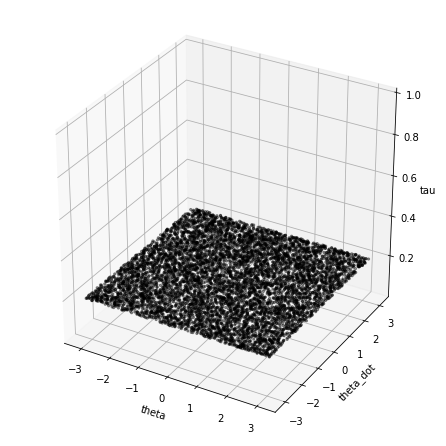

In [28]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(6,6))
ax = Axes3D(fig)
ax.set_xlabel('theta')
ax.set_ylabel('theta_dot')
ax.set_zlabel('tau')
ax.set_zlim3d(0.01,1.0)

ax.scatter3D(memory[:,0], memory[:,1], memory[:,2], marker='.', alpha=0.4, color='black')

In [33]:
a.actor.save_weights('./saved_agent/sample_02.h5')